In [20]:
import argparse
import numpy as np
import os
import pandas as pd
import tensorflow as tf
import tensorflow.lite as tflite
from tensorflow import keras
import zlib
from platform import python_version
import tensorflow_model_optimization as tfmot   
import tempfile
print(f"Python version used to excute the code is {python_version()}")



Python version used to excute the code is 3.7.5


In [21]:
# ######################################################## Input Parameters #########################################################
# parser = argparse.ArgumentParser()
# parser.add_argument('--model', type=str, required=True, help='model name')
# parser.add_argument('--mfcc', action='store_true', help='use MFCCs')
# args = parser.parse_args()

######################################################## Inputs and model selection  #########################################################

In [22]:
version = "a"
m = "cnn"   # model name [ mlp , cnn , ds_cnn  ]
mfcc = True    # True --> excute mfcc , False --> excute STFT
alpha = 0.3    # The width multiplier used to apply the structured Pruning 

model_version = f"_V_{version}_alpha={alpha}"

mymodel = m + model_version
TFLITE =  f'{mymodel}.tflite'                                   # path for saving the best model after converted to TF.lite model 
units = 8                                                       # The number of output class [8:without silence , 9 : with silence]
################## Fix the Random seed to reproduce the same results 
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [23]:



# zip_path = tf.keras.utils.get_file(
#     origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
#     fname='mini_speech_commands.zip',
#     extract=True,
#     cache_dir='.', cache_subdir='data')

# data_dir = os.path.join('.', 'data', 'mini_speech_commands')
data_dir = ('E:\Github\Machine-learning-for-IOT\Lab3\ex2\data\mini_speech_commands')

filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)

total = 8000          # NUMBER OF TOTAL Files Including THE Silence records 

train_files =   filenames[: int(total*0.8)]                                             # filenames[:int(total*0.8)]
val_files = filenames[int(total*0.8): int(total*0.9)]
test_files = filenames[int(total*0.9):]

# with silence ['stop', 'up', 'yes', 'right', 'left', 'no', 'silence', 'down', 'go']
LABELS = np.array(['stop', 'up', 'yes', 'right', 'left', 'no',  'down', 'go'] , dtype = str) 
print (f"The LABELS order as provided to the model are {LABELS}")

The LABELS order as provided to the model are ['stop' 'up' 'yes' 'right' 'left' 'no' 'down' 'go']


######################################################## Create the SignalGenerator #########################################################

In [24]:

class SignalGenerator:
    def __init__(self, labels, sampling_rate, frame_length, frame_step,
            num_mel_bins=None, lower_frequency=None, upper_frequency=None,
            num_coefficients=None, mfcc=False):
        self.labels = labels
        self.sampling_rate = sampling_rate                                             # 16000  
        self.frame_length = frame_length                                               # 640 
        self.frame_step = frame_step                                                   # 320 
        self.num_mel_bins = num_mel_bins                                               # 40 
        self.lower_frequency = lower_frequency                                         # 20 
        self.upper_frequency = upper_frequency                                         # 4000
        self.num_coefficients = num_coefficients                                       # 10 
        num_spectrogram_bins = (frame_length) // 2 + 1                                  # ( frame size // 2 ) + 1 

        '''
        STFT_OPTIONS = {'frame_length': 256, 'frame_step': 128, 'mfcc': False}
        MFCC_OPTIONS = {'frame_length': 640, 'frame_step': 320, 'mfcc': True,
        'lower_frequency': 20, 'upper_frequency': 4000, 'num_mel_bins': 40,
        'num_coefficients': 10}
        '''

        if mfcc is True:                                                                # Remember we need to compute this matrix once so it will be a class argument 
            self.linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
                    self.num_mel_bins, num_spectrogram_bins, self.sampling_rate,
                    self.lower_frequency, self.upper_frequency)
            self.preprocess = self.preprocess_with_mfcc
        else:
            self.preprocess = self.preprocess_with_stft

    def read(self, file_path):
        parts = tf.strings.split(file_path, os.path.sep)
        label = parts[-2]                                  # -1 is audio.wav so 
        label_id = tf.argmax(label == self.labels)
        audio_binary = tf.io.read_file(file_path)
        audio, _ = tf.audio.decode_wav(audio_binary)
        audio = tf.squeeze(audio, axis=1)

        return audio, label_id

    def pad(self, audio):
        # Padding for files with less than 16000 samples
        zero_padding = tf.zeros([self.sampling_rate] - tf.shape(audio), dtype=tf.float32)     # if the shape of the audio is already = 16000 (sampling rate) we will add nothing 

        # Concatenate audio with padding so that all audio clips will be of the  same length
        audio = tf.concat([audio, zero_padding], 0)
        # Unify the shape to the sampling frequency (16000 , )
        audio.set_shape([self.sampling_rate])

        return audio

    def get_spectrogram(self, audio):
        stft = tf.signal.stft(audio, frame_length=self.frame_length,
                frame_step=self.frame_step, fft_length=self.frame_length)
        spectrogram = tf.abs(stft)

        return spectrogram

    def get_mfccs(self, spectrogram):
        mel_spectrogram = tf.tensordot(spectrogram,
                self.linear_to_mel_weight_matrix, 1)
        log_mel_spectrogram = tf.math.log(mel_spectrogram + 1.e-6)
        mfccs = tf.signal.mfccs_from_log_mel_spectrograms(log_mel_spectrogram)
        mfccs = mfccs[..., :self.num_coefficients]

        return mfccs

    def preprocess_with_stft(self, file_path):
        audio, label = self.read(file_path)
        audio = self.pad(audio)
        spectrogram = self.get_spectrogram(audio)
        spectrogram = tf.expand_dims(spectrogram, -1)                         # expand_dims will not add or reduce elements in a tensor, it just changes the shape by adding 1 to dimensions for the batchs. 
    
        spectrogram = tf.image.resize(spectrogram, [32, 32])

        return spectrogram, label

    def preprocess_with_mfcc(self, file_path):
        audio, label = self.read(file_path)
        audio = self.pad(audio)
        spectrogram = self.get_spectrogram(audio)
        mfccs = self.get_mfccs(spectrogram)
        mfccs = tf.expand_dims(mfccs, -1)

        return mfccs, label

    def make_dataset(self, files, train):
        ds = tf.data.Dataset.from_tensor_slices(files)
        ds = ds.map(self.preprocess, num_parallel_calls = tf.data.experimental.AUTOTUNE) # better than 4 tf.data.experimental.AUTOTUNE will use the maximum num_parallel_calls 
        ds = ds.batch(32)
        ds = ds.cache()
        ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
        if train is True:
            ds = ds.shuffle(100, reshuffle_each_iteration=True)

        return ds


######################################################## Options for MFCC & STFT #########################################################

In [25]:
STFT_OPTIONS = {'frame_length': 256, 'frame_step': 128, 'mfcc': False}
MFCC_OPTIONS = {'frame_length': 640, 'frame_step': 320, 'mfcc': True,
        'lower_frequency': 20, 'upper_frequency': 4000, 'num_mel_bins': 40,
        'num_coefficients': 10}
if mfcc is True:
    options = MFCC_OPTIONS
    strides = [2, 1]
else:
    options = STFT_OPTIONS
    strides = [2, 2]



######################################################## Generate Data set splits #########################################################

In [26]:
generator = SignalGenerator(LABELS, 16000, **options)
train_ds = generator.make_dataset(train_files, True)
val_ds = generator.make_dataset(val_files, False)
test_ds = generator.make_dataset(test_files, False)

In [27]:
############## checking shapes and values of data sets 

In [28]:
# it = iter(val_ds)

In [29]:
# inp , label = next(it)
# print(inp.shape)
# print(label[0])

########################################################  building the models ########################################################

In [30]:


mlp = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units = int(256 *alpha), activation='relu' , name =  "Dense-1" ),
    tf.keras.layers.Dense(units = int(256 *alpha), activation='relu', name =  "Dense-2"),
    tf.keras.layers.Dense(units = int(256 *alpha), activation='relu', name =   "Dense-3" ),
    tf.keras.layers.Dense(units = units , name =  "Output-Layer")                                   # change to 9 if silence included 
])

cnn = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=int(128 *alpha), kernel_size=[3,3], strides=strides, use_bias=False , name = "Conv2D-1"),
    tf.keras.layers.BatchNormalization(momentum=0.1 , name = "Btch_Norm-1"),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Conv2D(filters=int(128 *alpha), kernel_size=[3,3], strides=[1,1], use_bias=False , name = "Conv2D-2"),
    tf.keras.layers.BatchNormalization(momentum=0.1 , name = "Btch_Norm-2"),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Conv2D(filters=int(128 *alpha), kernel_size=[3,3], strides=[1,1], use_bias=False , name = "Conv2D-3"),
    tf.keras.layers.BatchNormalization(momentum=0.1 , name = "Btch_Norm-3"),
    tf.keras.layers.ReLU(),
    tf.keras.layers.GlobalAveragePooling2D( name =  "GlobalAveragePooling-Layer"),
    tf.keras.layers.Dense(units = units, name =  "Output-Layer")
])

ds_cnn = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=int(256 *alpha), kernel_size=[3,3], strides=strides, use_bias=False, name = "Conv2D-1"),
    tf.keras.layers.BatchNormalization(momentum=0.1),
    tf.keras.layers.ReLU(),
    tf.keras.layers.DepthwiseConv2D(kernel_size=[3, 3], strides=[1, 1], use_bias=False, name = "DepthwiseConv2D-1"),
    tf.keras.layers.Conv2D(filters=int(256 *alpha), kernel_size=[1,1], strides=[1,1], use_bias=False, name = "Conv2D-2"),
    tf.keras.layers.BatchNormalization(momentum=0.1),
    tf.keras.layers.ReLU(),
    tf.keras.layers.DepthwiseConv2D(kernel_size=[3, 3], strides=[1, 1], use_bias=False, name = "DepthwiseConv2D-2"),
    tf.keras.layers.Conv2D(filters=int(256 *alpha), kernel_size=[1,1], strides=[1,1], use_bias=False, name = "Conv2D-3"),
    tf.keras.layers.BatchNormalization(momentum=0.1),
    tf.keras.layers.ReLU(),
    tf.keras.layers.GlobalAveragePooling2D( name =  "GlobalAveragePooling-Layer"),
    tf.keras.layers.Dense(units = units, name =  "Output-Layer")
])


MODELS = {'mlp'+ model_version : mlp, 'cnn'+ model_version: cnn, 'ds_cnn'+ model_version: ds_cnn}
print(MODELS.keys())

dict_keys(['mlp_V_a_alpha=0.3', 'cnn_V_a_alpha=0.3', 'ds_cnn_V_a_alpha=0.3'])


######################################################## Define optimizer & Losses & Metrics ########################################################

In [31]:

model = MODELS[mymodel]              # initiate the selected model 

loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.optimizers.Adam()
metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]


################### Compiling the model :

model.compile(loss = loss, optimizer = optimizer, metrics = metrics)

######################################################## check points depending on preprocessing STFT , MFCC 
if mfcc is False:
    checkpoint_filepath = f'./checkpoints/stft/chkp_best_{mymodel}'

else:
    checkpoint_filepath = f'./checkpoints/mfcc/chkp_best_{mymodel}'
    
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,           
    monitor='val_sparse_categorical_accuracy',
    verbose=1,
    mode='max',
    save_best_only=True,
    save_freq='epoch')

######################################################## Model Training ########################################################

In [32]:
history = model.fit(train_ds, epochs=1,   validation_data=val_ds,callbacks=[model_checkpoint_callback ])

############################## Print Model Summary ####################
print(model.summary())    


199/200 [============================>.] - ETA: 0s - loss: 1.7088 - sparse_categorical_accuracy: 0.4645
Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.70125, saving model to ./checkpoints/mfcc\chkp_best_cnn_V_a_alpha=0.3
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./checkpoints/mfcc\chkp_best_cnn_V_a_alpha=0.3\assets
200/200 [==============================] - 14s 71ms/step - loss: 1.7068 - sparse_categorical_accuracy: 0.4658 - val_loss: 1.2854 - val_sparse_categorical_accuracy: 0.7013
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2D-1 (Conv2D)            (None, 24, 8, 38)         342       
___________________________________________

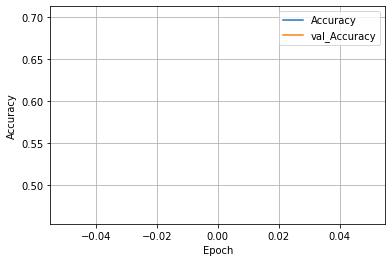

In [33]:
import matplotlib.pyplot as plt
def plot_loss(history):
    plt.plot(history.history['sparse_categorical_accuracy'], label='Accuracy')
    plt.plot(history.history['val_sparse_categorical_accuracy'], label='val_Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.savefig(mymodel+".png")

plot_loss(history)

######################################################## Function To Evaluate the best model and convert to TF Lite ########################################################

In [34]:
def S_pruning_Model_evaluate_and_compress_to_TFlite( tflite_model_dir =  TFLITE , checkpoint_filepath = checkpoint_filepath ):
    if not os.path.exists('./models'):
        os.makedirs('./models')
    best_model = tf.keras.models.load_model(filepath = checkpoint_filepath )
    Loss , ACCURACY = best_model.evaluate(test_ds)
    print("*"*50,"\n",f" The accuracy achieved by the best model before convertion = {ACCURACY *100:0.2f}% ")
    # Convert to TF lite without Quantization 
    converter = tf.lite.TFLiteConverter.from_saved_model(checkpoint_filepath)
    tflite_model = converter.convert()  
    Compressed = "compressed_"+tflite_model_dir 
    tflite_model_dir = './models/'+tflite_model_dir
    # Write the model in binary formate and save it 
    with open(tflite_model_dir, 'wb') as fp:
        fp.write(tflite_model)
    Compressed = './models/'+Compressed
    with open(Compressed, 'wb') as fp:
        tflite_compressed = zlib.compress(tflite_model)
        fp.write(tflite_compressed)
    print("*"*50,"\n",f"the model is saved successfuly to {tflite_model_dir}")
    return Compressed , tflite_model_dir 

In [35]:
def getsize(file):
    st = os.stat(file)
    size = st.st_size
    return size

######################################################## Function To Load  Evaluate the TF Lite  Model ########################################################

In [36]:
def load_and_evaluation(path, dataset , Compressed):
    interpreter = tf.lite.Interpreter(model_path = path) 
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    dataset = test_ds.unbatch().batch(1)
    
    COMMANDS = ['stop', 'up', 'yes', 'right', 'left', 'no',  'down', 'go']
    
    outputs = []
    labels = []
    count = 0                                 # counter to compute the number of correct predictions 
    total = 0                                 # total number of samples / predictions ==> acc = count/total
    
    for inp , label in dataset:
        my_input = np.array(inp, dtype = np.float32)
        label = np.array(label, dtype = np.float32)
    
         
        labels.append(label)

        interpreter.set_tensor(input_details[0]['index'], my_input)
        interpreter.invoke()
        my_output = interpreter.get_tensor(output_details[0]['index'])
        predict = np.argmax(my_output)                                 # the prediction crossponds to the index of with the highest probability   
        outputs.append(predict)
        total += 1   
        if (predict == label):                                         # if probability == labesl increase the correct predictions counter 
            count += 1
    # Compute the Accuracy         
    accuracy = count/total 
    # Evaluate the size of Tflite model 
    size = getsize(path)
    # Evaluate the size of Tflite model  after Comperession 
    size_compressed = getsize(Compressed)
    print ("*"*50,"\n",f"The Size of TF lite model  Before compression is = {size /1000 } kb" )
    print ("*"*50,"\n",f"The Size of TF lite model  After compression is = {size_compressed /1000 } kb" )
    print ("*"*50,"\n",f"The accuracy of TF lite model is = {accuracy *100 :0.2f} " )
    




######################################################## Generate Representitive data for Weight + activation Quantization ########################################################

In [37]:
# Function for weight and activations quantization 
def representative_dataset_gen():
    for x, _ in train_ds.take(1000):
        yield [x]

######################################################## Apply quantization Function ########################################################

In [38]:
def apply_Quantization(tflite_model_dir =  TFLITE ,  PQT = False , WAPQT = False ,  checkpoint_filepath = checkpoint_filepath ): 

    converter = tf.lite.TFLiteConverter.from_saved_model(checkpoint_filepath)
    
    # Apply weight only quantization 
    if PQT == True :
        tflite_model_dir = f"PQT_{tflite_model_dir}"
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
        tflite_model = converter.convert()
    # Apply weight + Activation  quantization 
    if WAPQT == True :
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
        converter.representative_dataset = representative_dataset_gen
        tflite_model = converter.convert()
        
        tflite_model_dir = f"WAPQT_{tflite_model_dir}"
    Compressed =  f"compressed_{tflite_model_dir}"
    tflite_model_dir =   f"./models/{tflite_model_dir}"
    # Write the model in binary formate and save it 
    with open(tflite_model_dir, 'wb') as fp:
        fp.write(tflite_model)
    Compressed = f"./models/{Compressed}"
    with open(Compressed, 'wb') as fp:
        tflite_compressed = zlib.compress(tflite_model)
        fp.write(tflite_compressed)
    print(f"the model is saved successfuly to {tflite_model_dir}")
    return Compressed , tflite_model_dir 

### Without Quantization

In [39]:
Compressed , tflite_model_dir = S_pruning_Model_evaluate_and_compress_to_TFlite( tflite_model_dir =  TFLITE , checkpoint_filepath = checkpoint_filepath )

25/25 [==============================] - 2s 73ms/step - loss: 1.2899 - sparse_categorical_accuracy: 0.6950
************************************************** 
  The accuracy achieved by the best model before convertion = 69.50% 
************************************************** 
 the model is saved successfuly to ./models/cnn_V_a_alpha=0.3.tflite


In [40]:
load_and_evaluation(tflite_model_dir, test_ds , Compressed)

************************************************** 
 The Size of TF lite model  Before compression is = 110.716 kb
************************************************** 
 The Size of TF lite model  After compression is = 100.918 kb
************************************************** 
 The accuracy of TF lite model is = 69.50 


### Weights only Quantization 

In [41]:
Compressed , Quantized   = apply_Quantization(PQT=True )

the model is saved successfuly to ./models/PQT_cnn_V_a_alpha=0.3.tflite


In [42]:
load_and_evaluation(Quantized , test_ds , Compressed)

************************************************** 
 The Size of TF lite model  Before compression is = 32.992 kb
************************************************** 
 The Size of TF lite model  After compression is = 28.234 kb
************************************************** 
 The accuracy of TF lite model is = 69.62 


### Weights only Quantization 

In [43]:
WA_Compressed , WA_Quantized   = apply_Quantization(WAPQT=True)

the model is saved successfuly to ./models/WAPQT_cnn_V_a_alpha=0.3.tflite


In [44]:
load_and_evaluation(WA_Quantized , test_ds , WA_Compressed)

************************************************** 
 The Size of TF lite model  Before compression is = 35.552 kb
************************************************** 
 The Size of TF lite model  After compression is = 29.789 kb
************************************************** 
 The accuracy of TF lite model is = 66.62 


## Quantization aware Training :

In [45]:
import tensorflow_model_optimization as tfmot

Q_aware_checkpoint_filepath = F'Q_aware_chkp_best_{mymodel}'
    
Q_aware_model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=Q_aware_checkpoint_filepath,           
    monitor='val_sparse_categorical_accuracy',
    verbose=1,
    mode='max',
    save_best_only=True,
    save_freq='epoch')

def Quantization_aware_traning(filepath = checkpoint_filepath , checkpoint_callback = Q_aware_model_checkpoint_callback ):

    quantize_model = tfmot.quantization.keras.quantize_model
    
    # Retrieve the best pre_trained model float 32 
    model = tf.keras.models.load_model(filepath = filepath )
    
    # Initiate a Quantization aware model from the Float 32 model to be trained 
    q_aware_model = quantize_model(model)
    
    # Model compile and define loss and metric 
    q_aware_model.compile(loss = loss, optimizer = optimizer, metrics = metrics)
    
    # Train the model for few epochs 
    q_aware_model_history = q_aware_model.fit(train_ds, epochs=10,   validation_data=val_ds,callbacks=[checkpoint_callback ])
    
    ############################## Print Model Summary ####################
    print(model.summary())
    
    # Evaluate the best model 
    best_model = tf.keras.models.load_model(filepath = Q_aware_checkpoint_filepath )
    Loss , ACCURACY = best_model.evaluate(test_ds)
    print("*"*50,"\n",f" The accuracy achieved by the best model before convertion = {ACCURACY *100:0.2f}% ")
    
    

######################################################## Apply quantization Aware Training on the Pre Trained Model ########################################################

In [46]:
Quantization_aware_traning(filepath = checkpoint_filepath , checkpoint_callback = Q_aware_model_checkpoint_callback )

Epoch 1/10
199/200 [============================>.] - ETA: 0s - loss: 1.0284 - sparse_categorical_accuracy: 0.7307
Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.80500, saving model to Q_aware_chkp_best_cnn_V_a_alpha=0.3
INFO:tensorflow:Assets written to: Q_aware_chkp_best_cnn_V_a_alpha=0.3\assets


INFO:tensorflow:Assets written to: Q_aware_chkp_best_cnn_V_a_alpha=0.3\assets


200/200 [==============================] - 7s 35ms/step - loss: 1.0274 - sparse_categorical_accuracy: 0.7310 - val_loss: 0.7562 - val_sparse_categorical_accuracy: 0.8050
Epoch 2/10
200/200 [==============================] - ETA: 0s - loss: 0.6840 - sparse_categorical_accuracy: 0.8283
Epoch 00002: val_sparse_categorical_accuracy improved from 0.80500 to 0.85500, saving model to Q_aware_chkp_best_cnn_V_a_alpha=0.3
INFO:tensorflow:Assets written to: Q_aware_chkp_best_cnn_V_a_alpha=0.3\assets


INFO:tensorflow:Assets written to: Q_aware_chkp_best_cnn_V_a_alpha=0.3\assets


200/200 [==============================] - 9s 47ms/step - loss: 0.6840 - sparse_categorical_accuracy: 0.8283 - val_loss: 0.5837 - val_sparse_categorical_accuracy: 0.8550
Epoch 3/10
200/200 [==============================] - ETA: 0s - loss: 0.5472 - sparse_categorical_accuracy: 0.8627
Epoch 00003: val_sparse_categorical_accuracy improved from 0.85500 to 0.87250, saving model to Q_aware_chkp_best_cnn_V_a_alpha=0.3
INFO:tensorflow:Assets written to: Q_aware_chkp_best_cnn_V_a_alpha=0.3\assets


INFO:tensorflow:Assets written to: Q_aware_chkp_best_cnn_V_a_alpha=0.3\assets


200/200 [==============================] - 9s 46ms/step - loss: 0.5472 - sparse_categorical_accuracy: 0.8627 - val_loss: 0.4888 - val_sparse_categorical_accuracy: 0.8725
Epoch 4/10
198/200 [============================>.] - ETA: 0s - loss: 0.4612 - sparse_categorical_accuracy: 0.8832
Epoch 00004: val_sparse_categorical_accuracy did not improve from 0.87250
200/200 [==============================] - 5s 24ms/step - loss: 0.4610 - sparse_categorical_accuracy: 0.8831 - val_loss: 0.4862 - val_sparse_categorical_accuracy: 0.8687
Epoch 5/10
198/200 [============================>.] - ETA: 0s - loss: 0.4031 - sparse_categorical_accuracy: 0.8930
Epoch 00005: val_sparse_categorical_accuracy did not improve from 0.87250
200/200 [==============================] - 5s 23ms/step - loss: 0.4036 - sparse_categorical_accuracy: 0.8930 - val_loss: 0.4664 - val_sparse_categorical_accuracy: 0.8625
Epoch 6/10
199/200 [============================>.] - ETA: 0s - loss: 0.3686 - sparse_categorical_accuracy: 0.89

INFO:tensorflow:Assets written to: Q_aware_chkp_best_cnn_V_a_alpha=0.3\assets


200/200 [==============================] - 8s 41ms/step - loss: 0.3303 - sparse_categorical_accuracy: 0.9122 - val_loss: 0.3780 - val_sparse_categorical_accuracy: 0.8863
Epoch 8/10
200/200 [==============================] - ETA: 0s - loss: 0.2996 - sparse_categorical_accuracy: 0.9189
Epoch 00008: val_sparse_categorical_accuracy improved from 0.88625 to 0.89500, saving model to Q_aware_chkp_best_cnn_V_a_alpha=0.3
INFO:tensorflow:Assets written to: Q_aware_chkp_best_cnn_V_a_alpha=0.3\assets


INFO:tensorflow:Assets written to: Q_aware_chkp_best_cnn_V_a_alpha=0.3\assets


200/200 [==============================] - 8s 41ms/step - loss: 0.2996 - sparse_categorical_accuracy: 0.9189 - val_loss: 0.3494 - val_sparse_categorical_accuracy: 0.8950
Epoch 9/10
199/200 [============================>.] - ETA: 0s - loss: 0.2802 - sparse_categorical_accuracy: 0.9231
Epoch 00009: val_sparse_categorical_accuracy improved from 0.89500 to 0.90000, saving model to Q_aware_chkp_best_cnn_V_a_alpha=0.3
INFO:tensorflow:Assets written to: Q_aware_chkp_best_cnn_V_a_alpha=0.3\assets


INFO:tensorflow:Assets written to: Q_aware_chkp_best_cnn_V_a_alpha=0.3\assets


200/200 [==============================] - 10s 50ms/step - loss: 0.2804 - sparse_categorical_accuracy: 0.9230 - val_loss: 0.3347 - val_sparse_categorical_accuracy: 0.9000
Epoch 10/10
199/200 [============================>.] - ETA: 0s - loss: 0.2616 - sparse_categorical_accuracy: 0.9318
Epoch 00010: val_sparse_categorical_accuracy improved from 0.90000 to 0.90250, saving model to Q_aware_chkp_best_cnn_V_a_alpha=0.3
INFO:tensorflow:Assets written to: Q_aware_chkp_best_cnn_V_a_alpha=0.3\assets


INFO:tensorflow:Assets written to: Q_aware_chkp_best_cnn_V_a_alpha=0.3\assets


200/200 [==============================] - 12s 58ms/step - loss: 0.2618 - sparse_categorical_accuracy: 0.9317 - val_loss: 0.3177 - val_sparse_categorical_accuracy: 0.9025
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2D-1 (Conv2D)            (None, 24, 8, 38)         342       
_________________________________________________________________
Btch_Norm-1 (BatchNormalizat (None, 24, 8, 38)         152       
_________________________________________________________________
re_lu_6 (ReLU)               (None, 24, 8, 38)         0         
_________________________________________________________________
Conv2D-2 (Conv2D)            (None, 22, 6, 38)         12996     
_________________________________________________________________
Btch_Norm-2 (BatchNormalizat (None, 22, 6, 38)         152       
_________________________________________________________________
re_lu_7 (ReLU) 

### Quantization Aware model saving

In [47]:
def Q_Aware_T_Tflite_save(filepath = Q_aware_checkpoint_filepath):
    QAT_tflite_model_dir = "Q_AWARE_Training_"+TFLITE
    converter = tf.lite.TFLiteConverter.from_saved_model(filepath)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    tflite_model = converter.convert()
    Compressed = "compressed_"+QAT_tflite_model_dir 
    QAT_tflite_model_dir = './models/'+QAT_tflite_model_dir
    # Write the model in binary formate and save it 
    with open(QAT_tflite_model_dir, 'wb') as fp:
        fp.write(tflite_model)
    Compressed = './models/'+Compressed
    with open(Compressed, 'wb') as fp:
        tflite_compressed = zlib.compress(tflite_model)
        fp.write(tflite_compressed)
    print("*"*50,"\n",f"the model is saved successfuly to {QAT_tflite_model_dir}")
    return QAT_tflite_model_dir , Compressed

In [48]:
QAT_tflite_model_dir , Q_Aware_T_Compressed = Q_Aware_T_Tflite_save(filepath = Q_aware_checkpoint_filepath)

************************************************** 
 the model is saved successfuly to ./models/Q_AWARE_Training_cnn_V_a_alpha=0.3.tflite


In [49]:
load_and_evaluation(QAT_tflite_model_dir, test_ds , Q_Aware_T_Compressed)

************************************************** 
 The Size of TF lite model  Before compression is = 35.448 kb
************************************************** 
 The Size of TF lite model  After compression is = 27.797 kb
************************************************** 
 The accuracy of TF lite model is = 91.75 
